# YouTube Recap

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import configparser

### Read the configuration file

In [19]:
config = configparser.ConfigParser()
config.read('config.ini')

['config.ini']

### Read the data

In [21]:
path = config['PATH']['path']
df_search = pd.read_json(f"{path}/history/search-history.json")

In [11]:
df_search.head()

,header,title,titleUrl,time,products,activityControls
0,YouTube,Searched for louis ck food,https://www.youtube.com/results?search_query=l...,2022-12-10T02:04:59.705Z,[YouTube],[YouTube search history]
1,YouTube,Searched for youtube api,https://www.youtube.com/results?search_query=y...,2022-12-10T02:02:15.742Z,[YouTube],[YouTube search history]
2,YouTube,Searched for netherlands vs argentina,https://www.youtube.com/results?search_query=n...,2022-12-09T22:57:54.612Z,[YouTube],[YouTube search history]
3,YouTube,Searched for Bill burr,https://www.youtube.com/results?search_query=B...,2022-12-09T19:14:34.837Z,[YouTube],[YouTube search history]
4,YouTube,Searched for Anthony Deakin,https://www.youtube.com/results?search_query=A...,2022-12-09T18:30:37.598Z,[YouTube],[YouTube search history]


# Search History

## Clean the data

#### drop unnecessary columns

In [8]:
df_search_clean = df_search.drop(['header', 'titleUrl', 'activityControls', 'products'], axis=1)

#### create a column for each search phrase

- create a column with only the search phrase
- create a function that removes first X words of the  

In [4]:
def remove_words(string, x):
    # split the string into a list of words
    words = string.split()
    
    # remove the first two words
    words = words[x:]
    
    # combine the remaining words into a new string
    new_string = " ".join(words)
    
    # return the new string
    return new_string


- remove the "searched for" before each search phrase in title

In [10]:
df_search_clean['phrase'] = df_search_clean['title'].apply(remove_words, x=2)

- drop title column

In [12]:
df_search_clean.drop(['title'], axis=1, inplace=True)

#### remove private info

- remove identifiable info from search history

In [24]:
text = config['WORDS']['words']

In [25]:
df_search_clean = df_search_clean[df_search_clean["phrase"].str.contains(text)==False]

- join every word that was searched into one string

In [26]:
words = ' '.join(df_search_clean['phrase'])

## Explore the data

### Searches per month

In [29]:
df_search_clean.head()

,time,phrase
0,2022-12-10T02:04:59.705Z,louis ck food
1,2022-12-10T02:02:15.742Z,youtube api
2,2022-12-09T22:57:54.612Z,netherlands vs argentina
3,2022-12-09T19:14:34.837Z,Bill burr
4,2022-12-09T18:30:37.598Z,Anthony Deakin


In [44]:
df_search_clean['time'] =  pd.to_datetime(df_search_clean['time'])

In [58]:
df_search_clean['month'] = pd.to_datetime(df_search_clean['time']).dt.month

In [59]:
df_search_clean['year'] = pd.to_datetime(df_search_clean['time']).dt.year

In [60]:
df_search_clean.head()

,time,phrase,month,year
0,2022-12-10 02:04:59.705000+00:00,louis ck food,12,2022
1,2022-12-10 02:02:15.742000+00:00,youtube api,12,2022
2,2022-12-09 22:57:54.612000+00:00,netherlands vs argentina,12,2022
3,2022-12-09 19:14:34.837000+00:00,Bill burr,12,2022
4,2022-12-09 18:30:37.598000+00:00,Anthony Deakin,12,2022


In [62]:
counts = pd.pivot_table(df_search_clean, index='month', columns='year', values='phrase', aggfunc='count')

In [88]:
counts

year,2019,2020,2021,2022
month,,,,
1,NaN,43.0,97.0,109.0
2,35.0,39.0,96.0,91.0
3,113.0,67.0,129.0,157.0
4,55.0,86.0,80.0,162.0
5,58.0,76.0,146.0,120.0
6,160.0,134.0,113.0,101.0
7,98.0,106.0,98.0,111.0
8,40.0,95.0,121.0,106.0
9,117.0,60.0,126.0,87.0


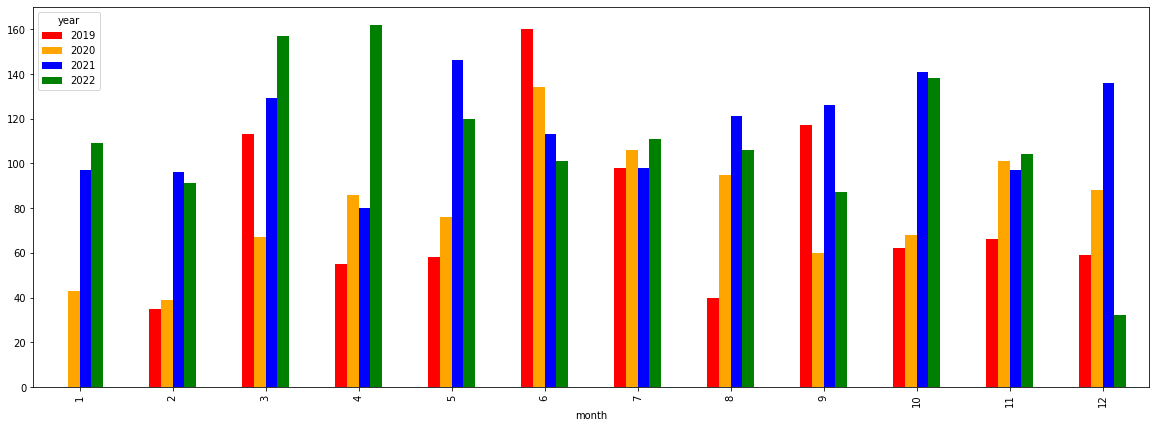

In [117]:
ax = counts.plot(kind='bar', color=['red', 'orange', 'blue', 'green'], figsize=(20, 7))

### Word cloud

In [32]:
from wordcloud import WordCloud

# # define the text
# text = "This is a sample text with some words that will appear in the word cloud"

# # create a word cloud from the text
# wordcloud = WordCloud().generate(text)

# # display the word cloud
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis("off")
# plt.show()

In [42]:
word_cloud = WordCloud(width = 1920, height = 1080,
                background_color ='black',
                min_font_size = 5).generate(words)

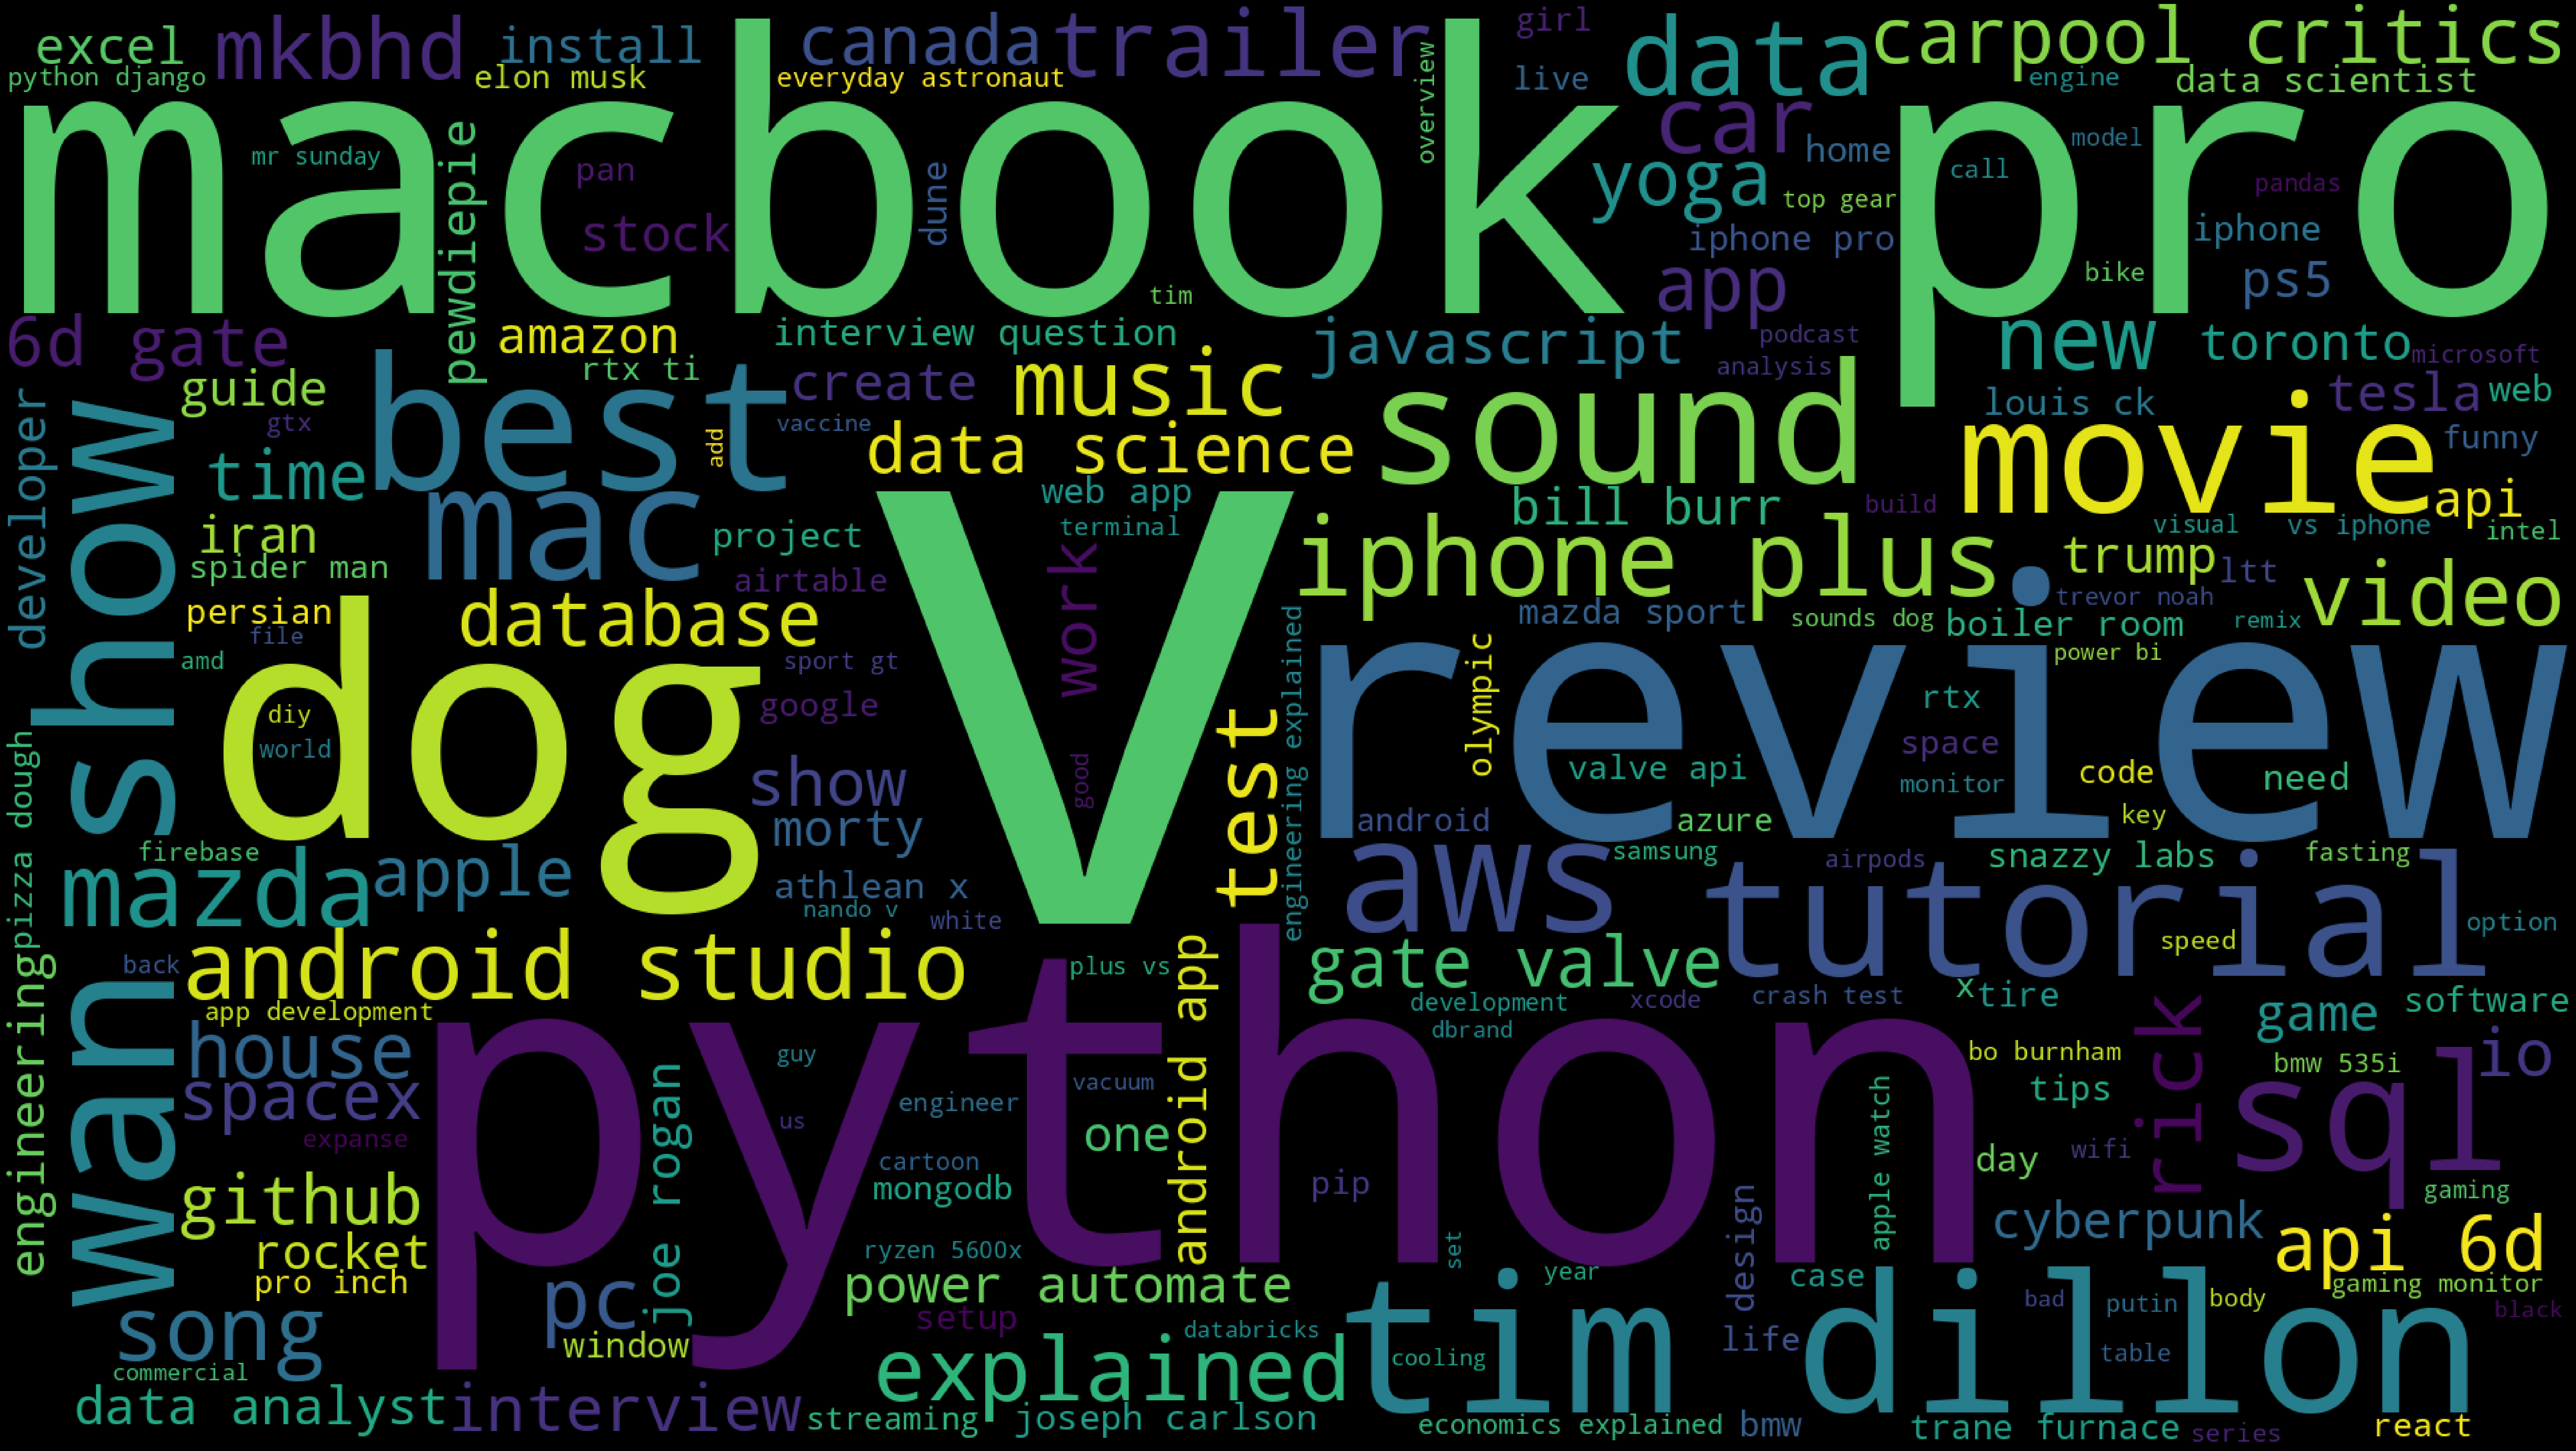

In [43]:
plt.figure(figsize = (100, 100), facecolor = 'black')
plt.imshow(word_cloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

# Watch history

### Read, parse, and clean watch history json file

In [ ]:
# Load the JSON file
with open(f"{path}/history/watch-history.json", 'r') as f:
    data = json.load(f)

# Initialize an empty list to store the parsed objects
parsed_objects = []

# Iterate over the objects in the JSON file
for obj in data:
    try:
        # Use json_normalize to parse the nested objects
        parsed = pd.json_normalize(obj, record_path='subtitles', meta=['header', 'title', 'titleUrl', 'time', 'products', 'activityControls'])
        parsed_objects.append(parsed)
    except KeyError:
        # If the 'subtitles' field is not present, skip the object
        continue

# Concatenate the parsed objects into a single dataframe
df_watch = pd.concat(parsed_objects)

df_watch = df_watch.rename(columns={'name': 'channel_name'})

In [ ]:
df_watch.head()

In [ ]:
df_watch_clean = df_watch.drop(columns=['header', 'titleUrl', 'products', 'activityControls'])

In [ ]:
df_watch_clean['title'] = df_watch_clean['title'].apply(remove_words, x=1)

In [ ]:
df_watch_clean.head()

In [ ]:
# df_watch_clean = df_watch_clean.drop(df_watch_clean[df_watch_clean['title'].str.contains(text)].index)

In [ ]:
df_watch_clean['time'] = pd.to_datetime(df_watch_clean['time'])

### Explore the data

In [ ]:
df_watch_clean.head()

In [ ]:
df_watch_clean.info()

In [ ]:
df_watch_clean.describe()

In [ ]:
df_watch_clean_2022 = df_watch_clean[df_watch_clean['time'].dt.year == 2022]

In [ ]:
df_watch_clean_2021 = df_watch_clean[df_watch_clean['time'].dt.year == 2021]

In [ ]:
df_watch_clean_2022

In [ ]:
df_watch_clean_2021

In [ ]:
df_watch_grouped_2022 = df_watch_clean_2022.groupby(df_watch_clean_2022['time'].dt.month).count()

In [ ]:
df_watch_grouped_2022_channels = df_watch_clean_2022.groupby(df_watch_clean_2022['channel_name']).count().reset_index()

In [ ]:
df_watch_grouped_2021 = df_watch_clean_2021.groupby(df_watch_clean_2021['time'].dt.month).count()

In [ ]:
df_watch_grouped_2021_channels = df_watch_clean_2021.groupby(df_watch_clean_2021['channel_name']).count().reset_index()

In [ ]:
df_watch_grouped_2022

In [ ]:
df_watch_grouped_2022_channels.sort_values(by=['title'], ascending=False)

In [ ]:
df_watch_grouped_2021

In [ ]:
df_watch_grouped_2021_channels.sort_values(by=['title'], ascending=False)

In [ ]:
df_watch_grouped_2022['title'].plot.bar(title='Videos watched per month in 2022')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()

In [ ]:
# select the top ten categories
top_ten = df_watch_grouped_2022_channels.nlargest(10, 'title')

# plot horizontal bar chart
top_ten.plot(kind='bar', x='channel_name', y='title', title="Videos watched per channel - 2022")

# show the plot
plt.show()

In [ ]:
df_watch_grouped_2021['title'].plot.bar(title='Videos watched per month in 2021')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()

In [ ]:
# select the top ten categories
top_ten = df_watch_grouped_2021_channels.nlargest(10, 'title')

# plot horizontal bar chart
top_ten.plot(kind='bar', x='channel_name', y='title', title="Videos watched per channel - 2021")

# show the plot
plt.show()

# Subscriptions

### Read the data

In [28]:
df_subs = pd.read_csv(f"{path}/subscriptions/subscriptions.csv")
# df_comments = pd.read_html(f"{path}/my-comments/my-comments.csv")